In [120]:
# from google.colab import drive
# drive.mount('/content/drive')

In [121]:
# import os
# path_dir= '/content/drive/MyDrive/Smart City/project'
# os.chdir(path_dir)

# Load the Data

In [122]:
# To access the data
!pip install ucimlrepo

Defaulting to user installation because normal site-packages is not writeable


In [123]:
from ucimlrepo import fetch_ucirepo
import pandas as pd

# fetch dataset
beijing_pm2_5 = fetch_ucirepo(id=381)

# data (as pandas dataframes)
df = pd.concat([beijing_pm2_5.data.features, beijing_pm2_5.data.targets], axis=1)

# metadata in a box
print(beijing_pm2_5.metadata)

# variable information
print(beijing_pm2_5.variables)

{'uci_id': 381, 'name': 'Beijing PM2.5', 'repository_url': 'https://archive.ics.uci.edu/dataset/381/beijing+pm2+5+data', 'data_url': 'https://archive.ics.uci.edu/static/public/381/data.csv', 'abstract': 'This hourly data set contains the PM2.5 data of US Embassy in Beijing. Meanwhile, meteorological data from Beijing Capital International Airport are also included. ', 'area': 'Climate and Environment', 'tasks': ['Regression'], 'characteristics': ['Multivariate', 'Time-Series'], 'num_instances': 43824, 'num_features': 11, 'feature_types': ['Integer', 'Real'], 'demographics': [], 'target_col': ['pm2.5'], 'index_col': ['No'], 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 2015, 'last_updated': 'Sat Mar 16 2024', 'dataset_doi': '10.24432/C5JS49', 'creators': ['Song Chen'], 'intro_paper': {'ID': 432, 'type': 'NATIVE', 'title': "Assessing Beijing's PM2.5 pollution: severity, weather impact, APEC and winter heating", 'authors': 'Xuan Liang, T. Zou, Bi

# Functions to aid Visualisation of our data


In [124]:
import matplotlib.pyplot as plt
import seaborn as sns

In [125]:
# Function to visualize outliers and distributions
def visualize_data(df, numerical_columns):
    """
    Creates boxplots, histograms, correlation heatmap, seasonal trends, and time series analysis.

    Parameters:
    df (DataFrame): The dataset.
    numerical_columns (list): List of numerical column names to visualize.
    datetime_col (str): Name of the datetime column.

    Returns:
    None (Displays the plots)
    """
    # Boxplots for outlier detection
    plt.figure(figsize=(15, 6))
    for i, col in enumerate(numerical_columns, 1):
        plt.subplot(2, len(numerical_columns) // 2 + 1, i)
        sns.boxplot(y=df[col])
        plt.title(f'Boxplot of {col}')
    plt.tight_layout()
    plt.show()

    # Histograms for distribution analysis
    plt.figure(figsize=(15, 6))
    for i, col in enumerate(numerical_columns, 1):
        plt.subplot(2, len(numerical_columns) // 2 + 1, i)
        sns.histplot(df[col], bins=50, kde=True)
        plt.title(f'Histogram of {col}')
    plt.tight_layout()
    plt.show()

    # Compute correlation matrix
    correlation_matrix = df[numerical_columns].corr()

    # Plot heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Correlation Heatmap of Variables")
    plt.show()

    # Seasonal trends (Boxplot for each month using index.month)
    # Ensure month order is correct (1 to 12)
    month_order = list(range(1, 13))

    # Plot Seasonal Trends - PM2.5 Boxplot by Month
    plt.figure(figsize=(12, 6))
    sns.boxplot(x=df['month'], y=df['pm2.5'], palette="Blues", order=month_order)
    plt.title('Monthly Variation of PM2.5 Levels')
    plt.xlabel('Month')
    plt.ylabel('PM2.5 Concentration')
    plt.show()

    # Ensure month order (list of month abbreviations)
    month_labels = pd.date_range('2023-01-01', periods=12, freq='M').strftime('%b')

    # Plot Monthly Temperature Trend (Averaged)
    plt.figure(figsize=(12, 6))
    df.groupby(df["month"])['TEMP'].mean().plot(marker='o', color='red', linewidth=2)
    plt.title('Monthly Average Temperature in Beijing (2010-2014)')
    plt.xlabel('Month')
    plt.ylabel('Temperature (°C)')
    # Set month names as x-axis labels
    plt.xticks(ticks=range(1, 13), labels=month_labels)
    plt.grid()
    plt.show()

    # Time series trend of pm2.5 levels (monthly mean) using index.month
    plt.figure(figsize=(12, 5))
    df['pm2.5'].resample('M').mean().plot(color='red', linewidth=2)
    plt.title('Monthly Average PM2.5 Levels (2010-2014)')
    plt.xlabel('Year')
    plt.ylabel('PM2.5 Concentration')
    plt.grid()
    plt.show()

In [126]:
# Define a function to detect outliers using IQR
def detect_outliers_iqr(df, columns):
    outlier_indices = {}

    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Find outlier indices
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)].index
        outlier_indices[col] = outliers

    return outlier_indices

In [127]:
def find_missing_ranges(df, column_name):
    """
    Identifies missing values in a column and groups continuous missing data as date/time ranges.

    Parameters:
    df (DataFrame): The dataset.
    column_name (str): The name of the column to check for missing values.

    Returns:
    List of tuples representing the ranges of missing data.
    """
    missing_indices = df[df[column_name].isna()].index

    if missing_indices.empty:
        return "No missing values found."

    # Identify continuous missing ranges
    missing_ranges = []
    start = missing_indices[0]

    for i in range(1, len(missing_indices)):
        if (missing_indices[i] - missing_indices[i - 1]) > pd.Timedelta("1D"):  # Check if gap > 1 day
            missing_ranges.append((start, missing_indices[i - 1]))
            start = missing_indices[i]

    # Append the last range
    missing_ranges.append((start, missing_indices[-1]))

    return missing_ranges


In [128]:
# Display the first few rows of the dataset
df.head()

,year,month,day,hour,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,pm2.5
0,2010,1,1,0,-21,-11.0,1021.0,NW,1.79,0,0,NaN
1,2010,1,1,1,-21,-12.0,1020.0,NW,4.92,0,0,NaN
2,2010,1,1,2,-21,-11.0,1019.0,NW,6.71,0,0,NaN
3,2010,1,1,3,-21,-14.0,1019.0,NW,9.84,0,0,NaN
4,2010,1,1,4,-20,-12.0,1018.0,NW,12.97,0,0,NaN


In [129]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43824 entries, 0 to 43823
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   year    43824 non-null  int64  
 1   month   43824 non-null  int64  
 2   day     43824 non-null  int64  
 3   hour    43824 non-null  int64  
 4   DEWP    43824 non-null  int64  
 5   TEMP    43824 non-null  float64
 6   PRES    43824 non-null  float64
 7   cbwd    43824 non-null  object 
 8   Iws     43824 non-null  float64
 9   Is      43824 non-null  int64  
 10  Ir      43824 non-null  int64  
 11  pm2.5   41757 non-null  float64
dtypes: float64(4), int64(7), object(1)
memory usage: 4.0+ MB


In [130]:
df.describe()

,year,month,day,hour,DEWP,TEMP,PRES,Iws,Is,Ir,pm2.5
count,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,41757.000000
mean,2012.000000,6.523549,15.727820,11.500000,1.817246,12.448521,1016.447654,23.889140,0.052734,0.194916,98.613215
std,1.413842,3.448572,8.799425,6.922266,14.433440,12.198613,10.268698,50.010635,0.760375,1.415867,92.050387
min,2010.000000,1.000000,1.000000,0.000000,-40.000000,-19.000000,991.000000,0.450000,0.000000,0.000000,0.000000
25%,2011.000000,4.000000,8.000000,5.750000,-10.000000,2.000000,1008.000000,1.790000,0.000000,0.000000,29.000000
50%,2012.000000,7.000000,16.000000,11.500000,2.000000,14.000000,1016.000000,5.370000,0.000000,0.000000,72.000000
75%,2013.000000,10.000000,23.000000,17.250000,15.000000,23.000000,1025.000000,21.910000,0.000000,0.000000,137.000000
max,2014.000000,12.000000,31.000000,23.000000,28.000000,42.000000,1046.000000,585.600000,27.000000,36.000000,994.000000


**Significant Observations from describe fucntion**-

1. The average dew point is 1.82°C and  a wide range from -40°C to 28°C. So significant variability in humidity conditions.

2. For temperature, The standard deviation is quite high at 12.20°C indicating diverse temperature conditions.

3. The average wind speed is about 23.89 m/s which is quite high. There is max value of 585.60 m/s indicating the dataset might have some sesor errors.

4. Snow (Is) and Rain (Ir): Both have very low mean values, suggesting that precipitation events are not frequent or intense in this dataset. The max values show that there are rare but significant events.

5. **PM2.5**: An average of 98.61 μg/m³ is alarmingly high considering WHO guidelines suggest an annual mean of 10 μg/m³ or less for good air quality. This indicates poor air quality. A high standard deviation of 92.05 shows large variability in PM2.5 levels which might correspond with different times of pollution sources.

In [131]:
df.dtypes

year       int64
month      int64
day        int64
hour       int64
DEWP       int64
TEMP     float64
PRES     float64
cbwd      object
Iws      float64
Is         int64
Ir         int64
pm2.5    float64
dtype: object

In [132]:
# Check for Null Values
df.isnull().sum()

year        0
month       0
day         0
hour        0
DEWP        0
TEMP        0
PRES        0
cbwd        0
Iws         0
Is          0
Ir          0
pm2.5    2067
dtype: int64

# Explore the Data

## Visualizing the Data

In [133]:
# Convert year, month, day, and hour into a full datetime column
df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])

In [134]:
# Set datetime as the index
df.set_index('datetime', inplace=True)

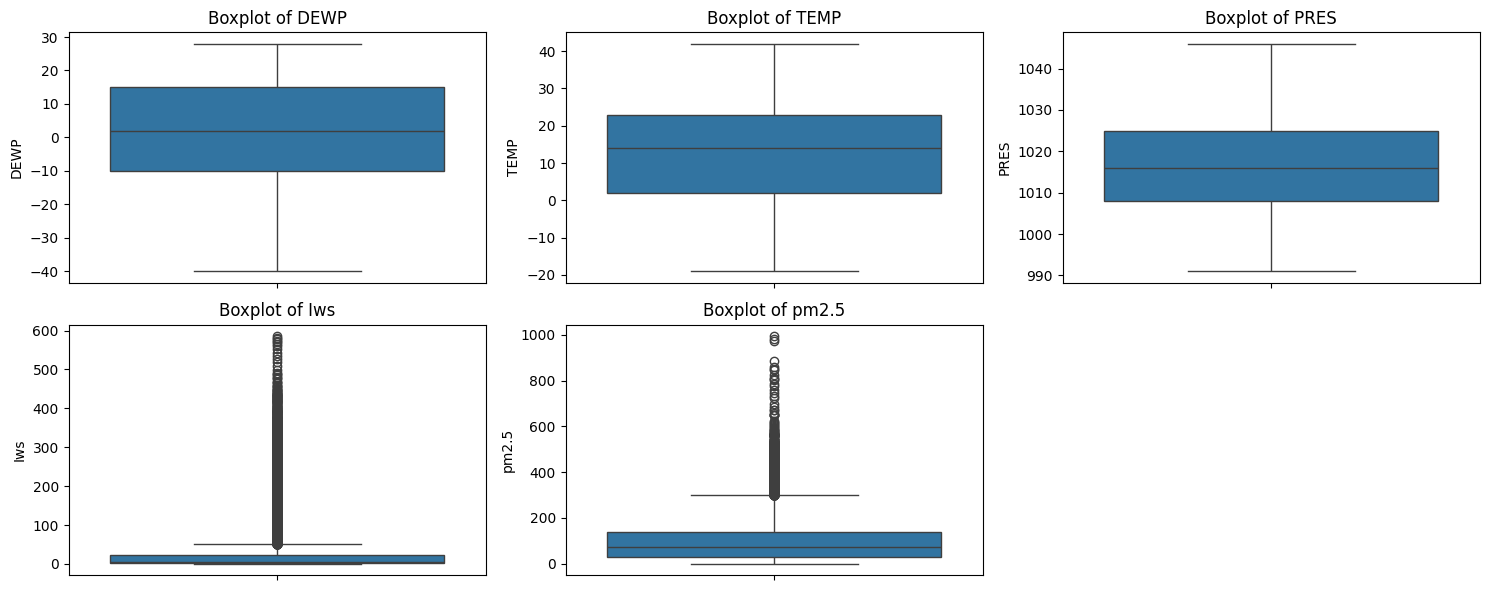

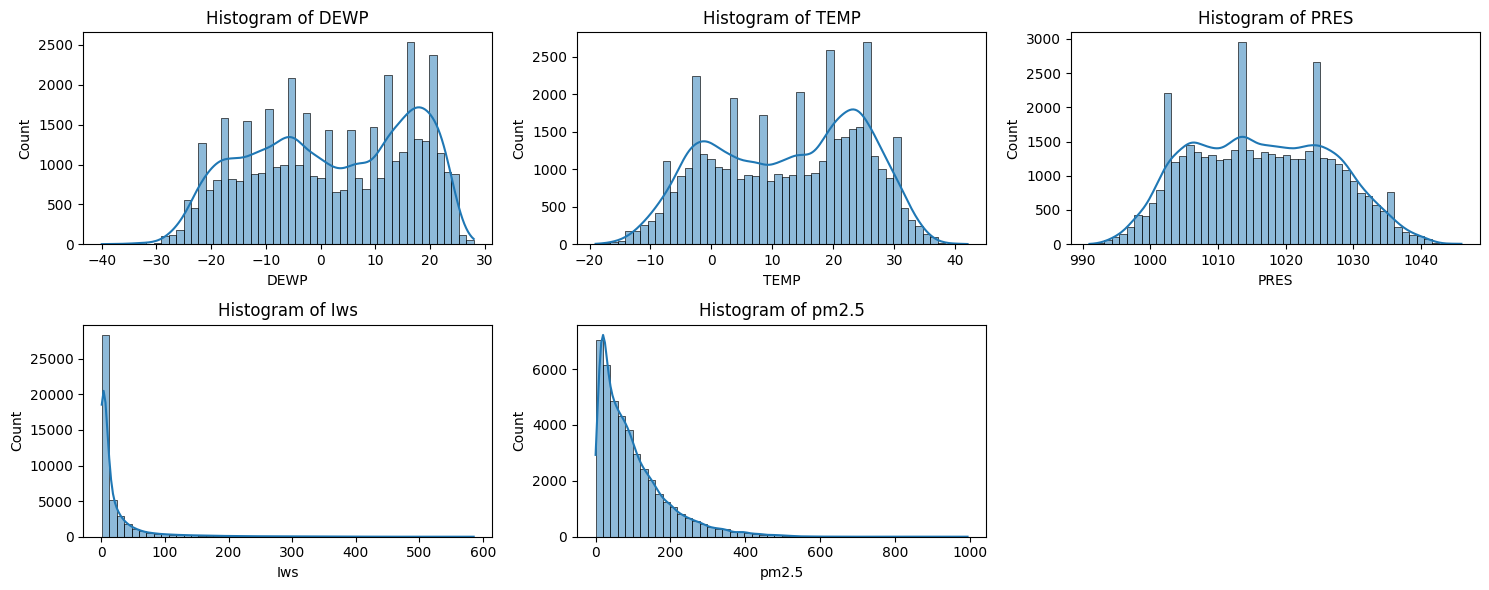

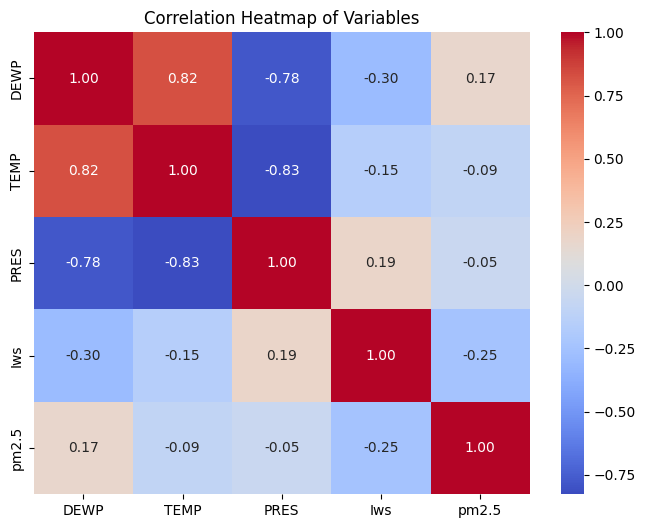

C:\Users\Jermiah Jerome\AppData\Local\Temp\ipykernel_111200\4094814222.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df['month'], y=df['pm2.5'], palette="Blues", order=month_order)


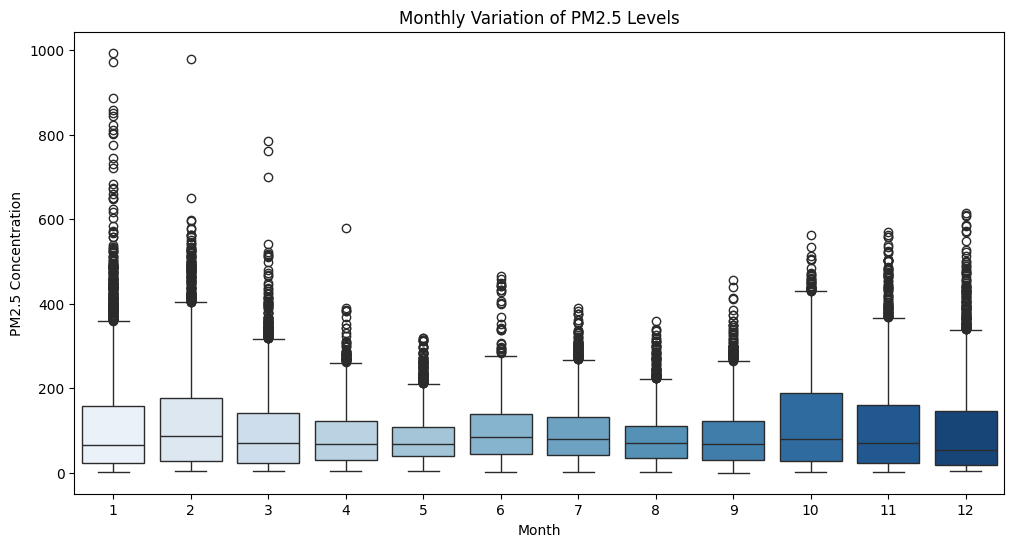

C:\Users\Jermiah Jerome\AppData\Local\Temp\ipykernel_111200\4094814222.py:54: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  month_labels = pd.date_range('2023-01-01', periods=12, freq='M').strftime('%b')


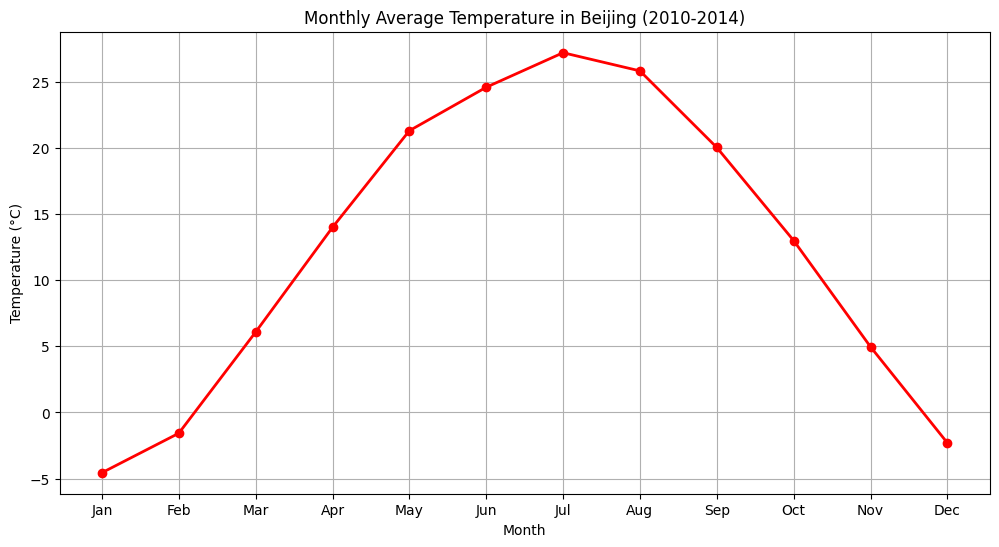

C:\Users\Jermiah Jerome\AppData\Local\Temp\ipykernel_111200\4094814222.py:69: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df['pm2.5'].resample('M').mean().plot(color='red', linewidth=2)


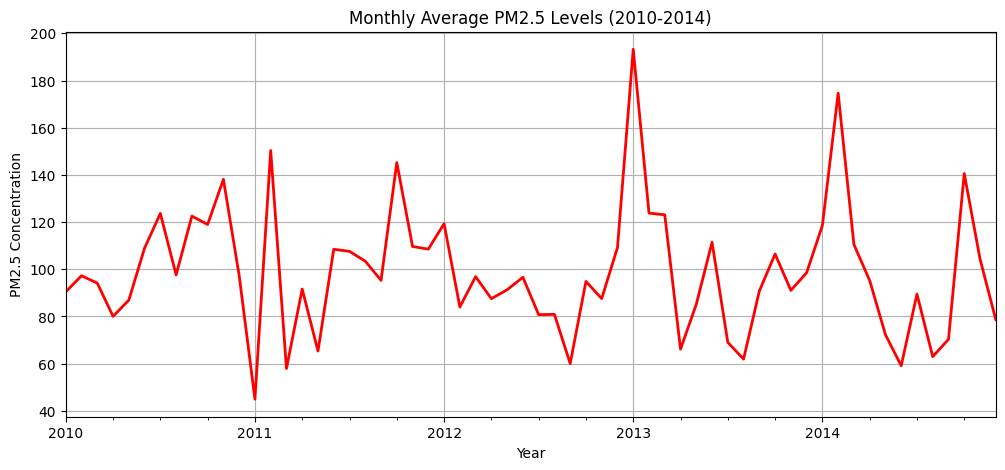

In [135]:
visualize_data(df, ['DEWP', 'TEMP', 'PRES', 'Iws', 'pm2.5'])

Interpretation of the Dataset
1. Seasonal Trends in PM2.5 Levels
Pollution levels are highest during winter months (November to February), likely due to increased heating emissions and atmospheric stagnation.
PM2.5 concentrations decrease during summer, suggesting that natural dispersion mechanisms, such as wind and temperature variations, help reduce pollution.
2. Meteorological Impact on Air Pollution
Wind speed has a negative correlation with PM2.5 levels, indicating that higher wind speeds help disperse pollutants.
Lower temperatures are associated with higher pollution levels, which may be due to the increased use of coal-based heating.
Pressure and humidity show minimal influence on pollution levels, suggesting that anthropogenic sources play a more significant role.
3. Extreme Pollution Events
Frequent high outliers in PM2.5 levels indicate periodic hazardous pollution episodes.
Some days record extreme pollution values exceeding 600-900 µg/m³, far beyond safe air quality thresholds.
4. Role of Traffic and Industrial Activity
High PM2.5 levels coincide with peak traffic hours, suggesting that vehicular emissions contribute significantly to air pollution.
Industrial activity may also be a key factor in pollution spikes, especially during colder months when emissions are higher.
Recommendations and Policy Implications
Implement real-time air quality alerts to inform the public about pollution levels and necessary precautions.
Introduce seasonal emission restrictions, particularly in winter, to control pollution from heating sources.
Implement traffic management measures, such as vehicle restrictions on high-pollution days, to reduce emissions.

# Data Preprocessing

The dataset contains the following columns:

No: Index (not useful for analysis)
year, month, day, hour: Time-related features
pm2.5: Air pollution measure (target variable)
DEWP: Dew point temperature (°C)
TEMP: Temperature (°C)
PRES: Pressure (hPa)
cbwd: Categorical wind direction
Iws: Cumulated wind speed (m/s)
Is: Cumulated hours of snow
Ir: Cumulated hours of rain

From the information gathered, we proceeded with data preprocessing by:

1. Data Cleaning

2. Handling missing values in pm2.5

3. Encoding categorical variables ​

## Data Cleaning

Checking unrealistic values in the dataset ( sensor errors)

Finding Unrealistic wind speed values

In [136]:
df.shape

(43824, 12)

In [137]:
# Count the number of records where wind speed (Iws) is greater than 120 m/s
df[df['Iws'] > 120].shape[0]


2048

In [138]:
df = df[df['Iws'] <= 120]  # Remove wind speeds above 120 m/s

In [139]:
df.shape

(41776, 12)

Finding Unrealistic PMI values ( may be sensor errors)

In [140]:
# Display only rows where "pm2.5" is zero
df[df["pm2.5"] == 0]

,year,month,day,hour,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,pm2.5
datetime,,,,,,,,,,,,


Ensures the Dew Point (DEWP) is not higher than the Temperature (TEMP)

What is Dew Point?
Dew Point (DEWP) is the temperature at which air reaches 100% humidity and condensation occurs (dew forms).
The dew point can never be higher than the actual temperature, because air cannot be saturated beyond 100% humidity.
Why is this check needed?
If DEWP > TEMP, it means there's an error in the data.

In [141]:
# Display rows where DEWP (Dew Point) is greater than TEMP (which is physically impossible)
df[df['DEWP'] > df['TEMP']]

,year,month,day,hour,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,pm2.5
datetime,,,,,,,,,,,,
2010-10-08 07:00:00,2010,10,8,7,13,12.0,1016.0,NW,0.89,0,0,349.0


In [142]:
df = df[df['DEWP'] <= df['TEMP']]

Finding Unrealistic Pressure Values

In [143]:
df[(df["PRES"] < 900) | (df["PRES"] > 1100)]

,year,month,day,hour,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,pm2.5
datetime,,,,,,,,,,,,


Finding Unrealistic Temperature Values

In [144]:
df[(df['TEMP'] < -50) | (df['TEMP'] > 60)]

,year,month,day,hour,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,pm2.5
datetime,,,,,,,,,,,,


Finding Unrealistic Pressure Values

In [145]:
df[(df["PRES"] < 850) | (df["PRES"] > 1100)]

,year,month,day,hour,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,pm2.5
datetime,,,,,,,,,,,,


In [146]:
# Identify outliers in selected columns
outliers = detect_outliers_iqr(df, ['DEWP', 'TEMP', 'PRES', 'Iws', 'pm2.5'])

# Print the number of outliers detected per column
for col, indices in outliers.items():
    print(f"Column: {col}, Outliers detected: {len(indices)}")


Column: DEWP, Outliers detected: 0
Column: TEMP, Outliers detected: 0
Column: PRES, Outliers detected: 0
Column: Iws, Outliers detected: 4251
Column: pm2.5, Outliers detected: 1738


 When Should You Retain Outliers?

1️⃣ When Outliers Represent Real Events
Outliers often correspond to significant real-world phenomena, such as:

- **High PM2.5 values** indicating pollution spikes, wildfires, or dust storms.
- **Extreme wind speeds** occurring during storms, typhoons, or hurricanes.
- **Unusually low pressure levels** associated with hurricanes or monsoons.

Since these values reflect actual events, they are retained to preserve critical insights for forecasting and analysis.

2️⃣ When Using Tree-Based Models (Random Forest, XGBoost, LightGBM)
Tree-based models are naturally resilient to outliers and do not require their removal. These models:

- Split data at optimal points, minimizing the influence of extreme values.
- Leverage outliers to capture meaningful patterns and trends.

Given their robustness, we retain outliers in tree-based models, as doing so enhances predictive performance rather than diminishing it.


## Handling missing values

In [147]:
df.isnull().sum()

year        0
month       0
day         0
hour        0
DEWP        0
TEMP        0
PRES        0
cbwd        0
Iws         0
Is          0
Ir          0
pm2.5    1970
dtype: int64

In [148]:
# Run the function for pm2.5 missing values
missing_ranges_pm25 = find_missing_ranges(df, "pm2.5")
missing_ranges_pm25


[(Timestamp('2010-01-01 00:00:00'), Timestamp('2010-01-01 23:00:00')),
 (Timestamp('2010-01-23 17:00:00'), Timestamp('2010-01-26 11:00:00')),
 (Timestamp('2010-02-14 02:00:00'), Timestamp('2010-02-14 02:00:00')),
 (Timestamp('2010-03-20 05:00:00'), Timestamp('2010-03-20 06:00:00')),
 (Timestamp('2010-03-22 23:00:00'), Timestamp('2010-03-22 23:00:00')),
 (Timestamp('2010-03-30 06:00:00'), Timestamp('2010-03-31 16:00:00')),
 (Timestamp('2010-05-17 17:00:00'), Timestamp('2010-05-17 18:00:00')),
 (Timestamp('2010-05-27 19:00:00'), Timestamp('2010-05-27 23:00:00')),
 (Timestamp('2010-06-01 16:00:00'), Timestamp('2010-06-02 16:00:00')),
 (Timestamp('2010-06-04 12:00:00'), Timestamp('2010-06-09 16:00:00')),
 (Timestamp('2010-06-20 08:00:00'), Timestamp('2010-06-20 09:00:00')),
 (Timestamp('2010-06-22 10:00:00'), Timestamp('2010-06-23 09:00:00')),
 (Timestamp('2010-08-13 20:00:00'), Timestamp('2010-08-16 15:00:00')),
 (Timestamp('2010-09-11 06:00:00'), Timestamp('2010-09-11 21:00:00')),
 (Time

In [149]:

df["pm2.5"] = df["pm2.5"].fillna(method="ffill").interpolate(method="time")


C:\Users\Jermiah Jerome\AppData\Local\Temp\ipykernel_111200\2883689555.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["pm2.5"] = df["pm2.5"].fillna(method="ffill").interpolate(method="time")


In [150]:
df["pm2.5"].isnull().sum()

24

In [151]:
missing_ranges_pm25 = find_missing_ranges(df, "pm2.5")
missing_ranges_pm25


[(Timestamp('2010-01-01 00:00:00'), Timestamp('2010-01-01 23:00:00'))]

Remaining NA values are in beginning of the dataset. We can drop them as they are very few.

In [152]:
df.dropna(inplace=True)

In [153]:
# Find the minimum and maximum dates using the index
min_date = df.index.min()
max_date = df.index.max()

print(f"Minimum date: {min_date}")
print(f"Maximum date: {max_date}")


Minimum date: 2010-01-02 00:00:00
Maximum date: 2014-12-31 05:00:00


In [154]:
# YOUR CODE
# Number of unique items
unique_items = df['cbwd'].nunique()  # Replace 'item_column' with the actual column name for items

print(f"Number of wind directions: {unique_items}")

Number of wind directions: 4


In [155]:
df["pm2.5"].describe()

count    41751.000000
mean       101.424469
std         91.859640
min          1.000000
25%         33.000000
50%         76.000000
75%        140.000000
max        994.000000
Name: pm2.5, dtype: float64

# Fetaure Engineering

## Encoding Categorical Variables

In [156]:
# Encode categorical variable 'cbwd' using one-hot encoding
df = pd.get_dummies(df, columns=['cbwd'])
df.head()

,year,month,day,hour,DEWP,TEMP,PRES,Iws,Is,Ir,pm2.5,cbwd_NE,cbwd_NW,cbwd_SE,cbwd_cv
datetime,,,,,,,,,,,,,,,
2010-01-02 00:00:00,2010,1,2,0,-16,-4.0,1020.0,1.79,0,0,129.0,False,False,True,False
2010-01-02 01:00:00,2010,1,2,1,-15,-4.0,1020.0,2.68,0,0,148.0,False,False,True,False
2010-01-02 02:00:00,2010,1,2,2,-11,-5.0,1021.0,3.57,0,0,159.0,False,False,True,False
2010-01-02 03:00:00,2010,1,2,3,-7,-5.0,1022.0,5.36,1,0,181.0,False,False,True,False
2010-01-02 04:00:00,2010,1,2,4,-7,-5.0,1022.0,6.25,2,0,138.0,False,False,True,False


In [157]:
!pip install chinese-calendar

In [158]:
!pip install tqdm


1️⃣ Business & Contextual Relevance
Before jumping into data analysis, let's think logically:

Holidays (is_holiday) might impact pollution levels, traffic, and industrial activity.
Events (is_event) such as government meetings, sports, or celebrations could lead to:
Increased or reduced emissions (e.g., factories shutting down or more vehicles on the road).
Government interventions (e.g., temporary policies to improve air quality).

Hypothesis:

If pollution levels (PM2.5) drop on special events, it may indicate government pollution control policies.
If holidays affect pollution levels, it could be due to reduced industrial activity or increased travel.

In [ ]:
from chinese_calendar import is_holiday
from tqdm import tqdm

#  Load Beijing events dataset
events_filename = "./Beijing_events.csv"
events_df = pd.read_csv(events_filename)

# Convert event dates to datetime
events_df["date0"] = pd.to_datetime(events_df["date0"])
events_df["date1"] = pd.to_datetime(events_df["date1"])

# Function to check for holidays & events
def check_date_features(row):
    dt = pd.Timestamp(row.name)  # Convert index to Timestamp (datetime64[ns])

    # Check if it's a holiday
    row["is_holiday"] = int(is_holiday(dt.date()))  # Convert to date() only for `is_holiday`

    # Check if the date falls within any event period
    event_occurrences = events_df[(events_df["date0"] <= dt) & (dt <= events_df["date1"])]

    row["is_event"] = 1 if not event_occurrences.empty else 0  # Mark 1 if it's an event, else 0

    return row[["is_holiday", "is_event"]]


# Apply function with progress bar
tqdm.pandas(desc="Generating holiday & event features")
datetime_features = df.progress_apply(check_date_features, axis=1)

# Merge new features into the main DataFrame
df = df.join(datetime_features)

Generating holiday & event features: 100%|██████████| 41751/41751 [01:21<00:00, 515.42it/s]


In [160]:
df.head()

,year,month,day,hour,DEWP,TEMP,PRES,Iws,Is,Ir,pm2.5,cbwd_NE,cbwd_NW,cbwd_SE,cbwd_cv,is_holiday,is_event
datetime,,,,,,,,,,,,,,,,,
2010-01-02 00:00:00,2010,1,2,0,-16,-4.0,1020.0,1.79,0,0,129.0,False,False,True,False,1,0
2010-01-02 01:00:00,2010,1,2,1,-15,-4.0,1020.0,2.68,0,0,148.0,False,False,True,False,1,0
2010-01-02 02:00:00,2010,1,2,2,-11,-5.0,1021.0,3.57,0,0,159.0,False,False,True,False,1,0
2010-01-02 03:00:00,2010,1,2,3,-7,-5.0,1022.0,5.36,1,0,181.0,False,False,True,False,1,0
2010-01-02 04:00:00,2010,1,2,4,-7,-5.0,1022.0,6.25,2,0,138.0,False,False,True,False,1,0


In [161]:
# Cunt the number of holidays in the dataset
holiday_count = df["is_holiday"].sum()

# Count the number of events in the dataset
event_count = df["is_event"].sum()

# Print results
print(f"Total Holidays in Dataset: {holiday_count}")
print(f"Total Events in Dataset: {event_count}")


Total Holidays in Dataset: 13252
Total Events in Dataset: 2354


In [162]:
df.groupby(df.index.year)[["is_holiday", "is_event"]].sum()


,is_holiday,is_event
datetime,,
2010,2623,485
2011,2607,436
2012,2657,424
2013,2694,357
2014,2671,652


In [163]:
df.groupby(df.index.month)[["is_holiday", "is_event"]].sum()


,is_holiday,is_event
datetime,,
1,1104,49
2,1262,75
3,1014,1876
4,1128,99
5,1136,190
6,1176,0
7,1056,0
8,1056,0
9,1032,0


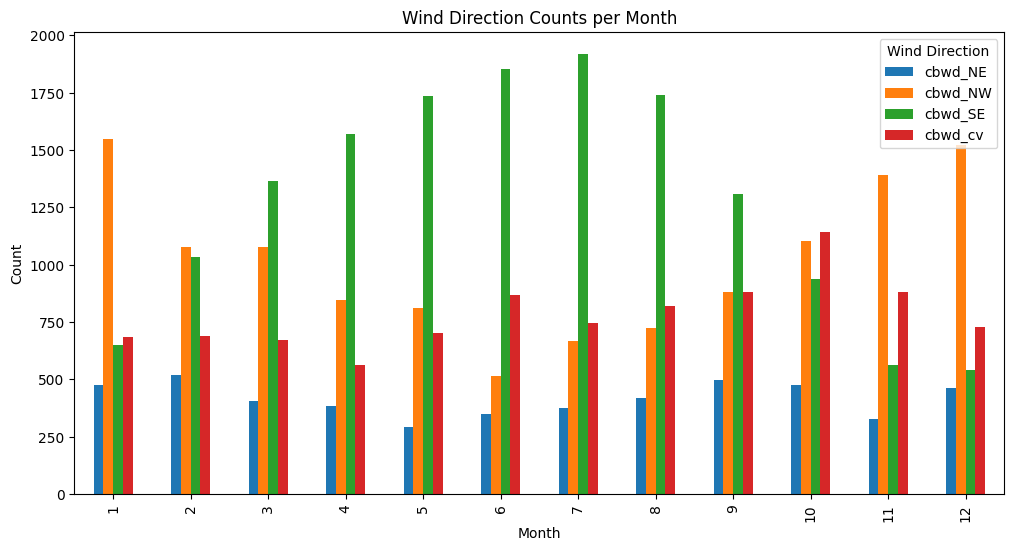

In [164]:
# Group by month and count occurrences of different wind directions
wind_counts = df.groupby(df.index.month)[["cbwd_NE", "cbwd_NW", "cbwd_SE", "cbwd_cv"]].sum()

# Plot seasonal wind patterns
wind_counts.plot(kind="bar", figsize=(12, 6), title="Wind Direction Counts per Month")
plt.xlabel("Month")
plt.ylabel("Count")
plt.legend(title="Wind Direction")
plt.show()

In [165]:
df["dayofweek"] = df.index.dayofweek  # Monday=0, Sunday=6
df["is_weekend"] = (df["dayofweek"] >= 5).astype(int)  # 1 if Sat/Sun, else 0
df["is_night"] = ((df["hour"] >= 20) | (df["hour"] <= 6)).astype(int)  # 1 if night


In [166]:
df.head()

,year,month,day,hour,DEWP,TEMP,PRES,Iws,Is,Ir,pm2.5,cbwd_NE,cbwd_NW,cbwd_SE,cbwd_cv,is_holiday,is_event,dayofweek,is_weekend,is_night
datetime,,,,,,,,,,,,,,,,,,,,
2010-01-02 00:00:00,2010,1,2,0,-16,-4.0,1020.0,1.79,0,0,129.0,False,False,True,False,1,0,5,1,1
2010-01-02 01:00:00,2010,1,2,1,-15,-4.0,1020.0,2.68,0,0,148.0,False,False,True,False,1,0,5,1,1
2010-01-02 02:00:00,2010,1,2,2,-11,-5.0,1021.0,3.57,0,0,159.0,False,False,True,False,1,0,5,1,1
2010-01-02 03:00:00,2010,1,2,3,-7,-5.0,1022.0,5.36,1,0,181.0,False,False,True,False,1,0,5,1,1
2010-01-02 04:00:00,2010,1,2,4,-7,-5.0,1022.0,6.25,2,0,138.0,False,False,True,False,1,0,5,1,1


## Autocorrelation Function (ACF) for PM2.5

<Figure size 1000x500 with 0 Axes>

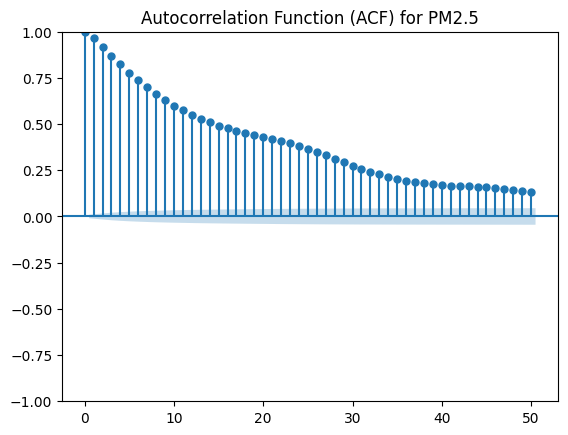

In [167]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# Plot ACF for PM2.5
plt.figure(figsize=(10, 5))
plot_acf(df["pm2.5"], lags=50)  # Check up to 50 lags
plt.title("Autocorrelation Function (ACF) for PM2.5")
plt.show()


<Figure size 1000x500 with 0 Axes>

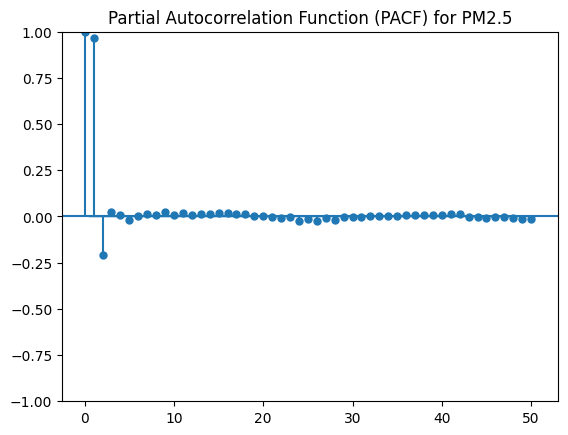

In [168]:
from statsmodels.graphics.tsaplots import plot_pacf

# Plot PACF for PM2.5
plt.figure(figsize=(10, 5))
plot_pacf(df["pm2.5"].dropna(), lags=50)  # Check up to 50 lags
plt.title("Partial Autocorrelation Function (PACF) for PM2.5")
plt.show()


In [169]:
lags = [1, 3, 24]  # Selected based on ACF & PACF

for lag in lags:
    df[f"pm2.5_lag_{lag}"] = df["pm2.5"].shift(lag)

# Drop NaN values introduced by shifting
df.dropna(inplace=True)



In [170]:
df["pm2.5_rolling_mean_3"] = df["pm2.5"].rolling(window=3).mean().shift(1)
df["pm2.5_rolling_std_3"] = df["pm2.5"].rolling(window=3).std().shift(1)

df["pm2.5_rolling_mean_12"] = df["pm2.5"].rolling(window=12).mean().shift(1)
df["pm2.5_rolling_std_12"] = df["pm2.5"].rolling(window=12).std().shift(1)


In [171]:
# Drop NaNs introduced by rolling calculations
df.dropna(inplace=True)

# Model Training

In [172]:
df = df.sort_index()
# Define the train-test split (80% training, 20% testing)
train_size = 0.8
train_index = int(len(df) * train_size)

train = df.iloc[:train_index]  # First 80% as training
test = df.iloc[train_index:]   # Last 20% as test

# Define features and target
features = [col for col in df.columns if col not in ["pm2.5"]]  # Exclude target
target = "pm2.5"

X_train, y_train = train[features], train[target]
X_test, y_test = test[features], test[target]


In [173]:
print("Train Start Date:", train.index.min(), " -> Train End Date:", train.index.max())
print("Test Start Date:", test.index.min(), " -> Test End Date:", test.index.max())


Train Start Date: 2010-01-03 12:00:00  -> Train End Date: 2014-01-06 10:00:00
Test Start Date: 2014-01-06 11:00:00  -> Test End Date: 2014-12-31 05:00:00


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001337 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2364
[LightGBM] [Info] Number of data points in the train set: 33372, number of used features: 26
[LightGBM] [Info] Start training from score 101.655040
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

,Model,MAE,MSE,RMSE,R2 Score
0,Random Forest,13.151592,509.086830,22.562953,0.943078
1,XGBoost,14.195926,555.666195,23.572573,0.937870
2,LightGBM,11.647105,446.602040,21.132961,0.950064


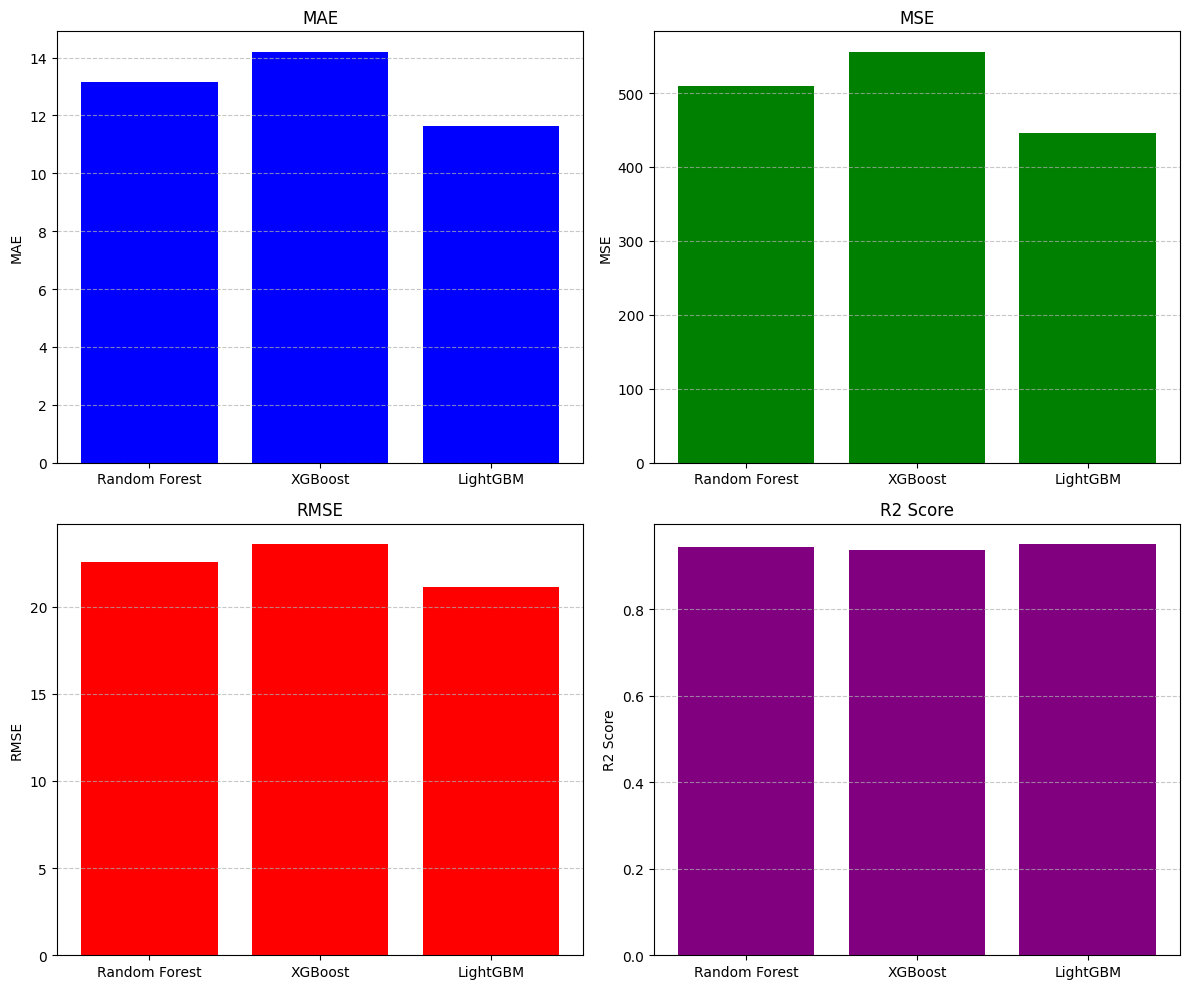

In [174]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# Define models
models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, max_depth=6, random_state=42),
    "LightGBM": LGBMRegressor(n_estimators=100, max_depth=6, random_state=42)
}

# Function to train and evaluate models
def train_and_evaluate(models, X_train, X_test, y_train, y_test):
    results = []
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        results.append({
            "Model": name,
            "MAE": mean_absolute_error(y_test, y_pred),
            "MSE": mean_squared_error(y_test, y_pred),
            "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
            "R2 Score": r2_score(y_test, y_pred)
        })
    return pd.DataFrame(results)

# Train models and evaluate performance
model_results_df = train_and_evaluate(models, X_train, X_test, y_train, y_test)

# Display the model evaluation results in text format
print("\n### Model Evaluation Results ###")
display(model_results_df)

# Plot Model Evaluation Metrics
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
metrics = ["MAE", "MSE", "RMSE", "R2 Score"]
colors = ["blue", "green", "red", "purple"]

for i, metric in enumerate(metrics):
    ax = axes[i//2, i%2]
    ax.bar(model_results_df["Model"], model_results_df[metric], color=colors[i])
    ax.set_title(metric)
    ax.set_ylabel(metric)
    ax.grid(axis='y', linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()



In [ ]:
!pip install shap

Defaulting to user installation because normal site-packages is not writeable


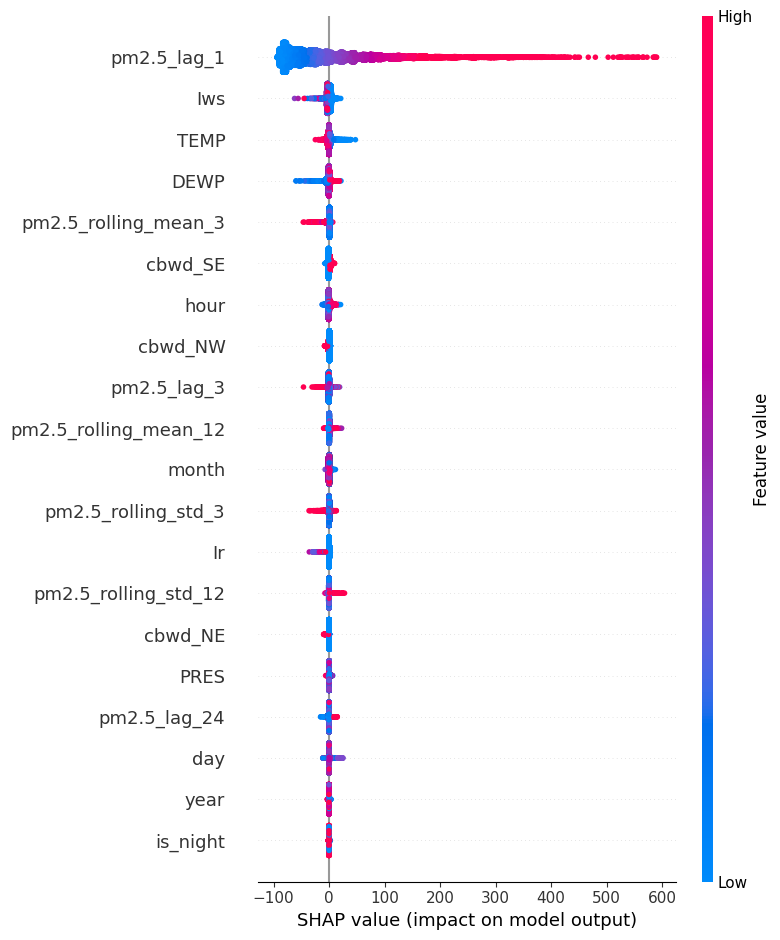

In [179]:
import shap

# Ensure LightGBM model is trained before applying SHAP
best_model = models["LightGBM"]

# Initialize SHAP explainer
explainer = shap.TreeExplainer(best_model)

# Compute SHAP values
shap_values = explainer.shap_values(X_train)

# Plot the SHAP summary plot
shap.summary_plot(shap_values, X_train)



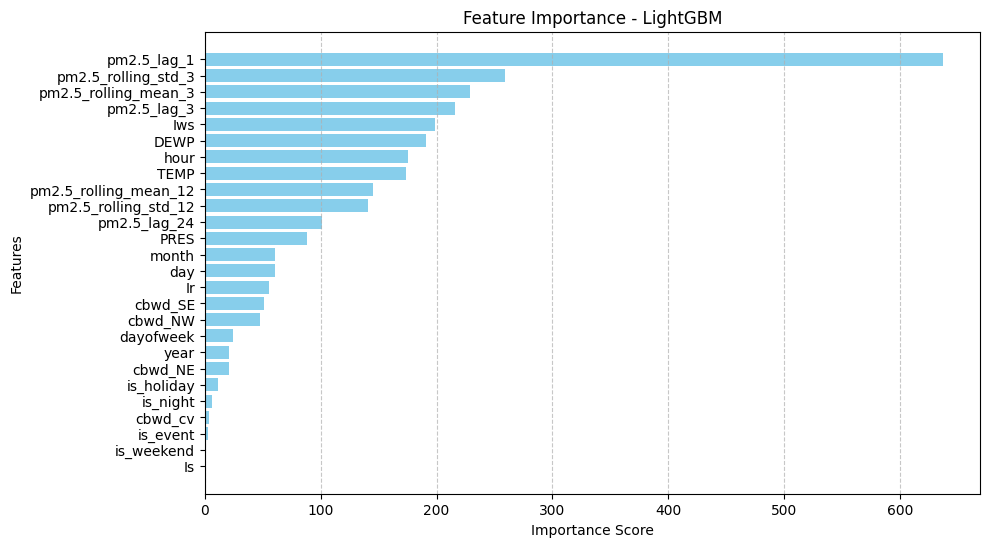

In [180]:
# Extract feature importance from LightGBM
feature_importance = best_model.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False)

# Plot Feature Importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df["Feature"], feature_importance_df["Importance"], color="skyblue")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance - LightGBM")
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()


# Hyper Parameter tuning

In [115]:
#!pip install --upgrade scikit-learn xgboost

In [116]:

import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define parameter grid for hyperparameter tuning
param_dist = {
    "num_leaves": np.arange(20, 150, 10),
    "max_depth": np.arange(3, 15, 1),
    "learning_rate": np.linspace(0.01, 0.3, 10),
    "n_estimators": np.arange(50, 500, 50),
    "subsample": np.linspace(0.6, 1.0, 5),
    "colsample_bytree": np.linspace(0.6, 1.0, 5),
    "reg_alpha": np.linspace(0, 1, 10),
    "reg_lambda": np.linspace(0, 1, 10)
}

# Time Series Cross-Validation
tscv = TimeSeriesSplit(n_splits=5)

# Initialize LightGBM model
lgb_model = lgb.LGBMRegressor()

# Perform randomized search with time series CV
random_search = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=param_dist,
    n_iter=30,  # Reduce iterations for speed
    cv=tscv,  # Time series split
    verbose=1,
    n_jobs=-1,
    random_state=42,
    scoring="neg_mean_squared_error"
)

# Fit model
random_search.fit(X_train, y_train)

# Get best parameters
best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

# Train final LightGBM model with best parameters
best_lgbm = lgb.LGBMRegressor(**best_params)
best_lgbm.fit(X_train, y_train)

# Predictions
y_pred = best_lgbm.predict(X_test)

# Evaluate model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)


# Display results
print(f"Optimized LightGBM Results:\nMAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")

# Create a DataFrame for visualization
results_df = pd.DataFrame({"Actual": y_test.values, "Predicted": y_pred}, index=y_test.index)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016132 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2364
[LightGBM] [Info] Number of data points in the train set: 33372, number of used features: 26
[LightGBM] [Info] Start training from score 101.655040
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

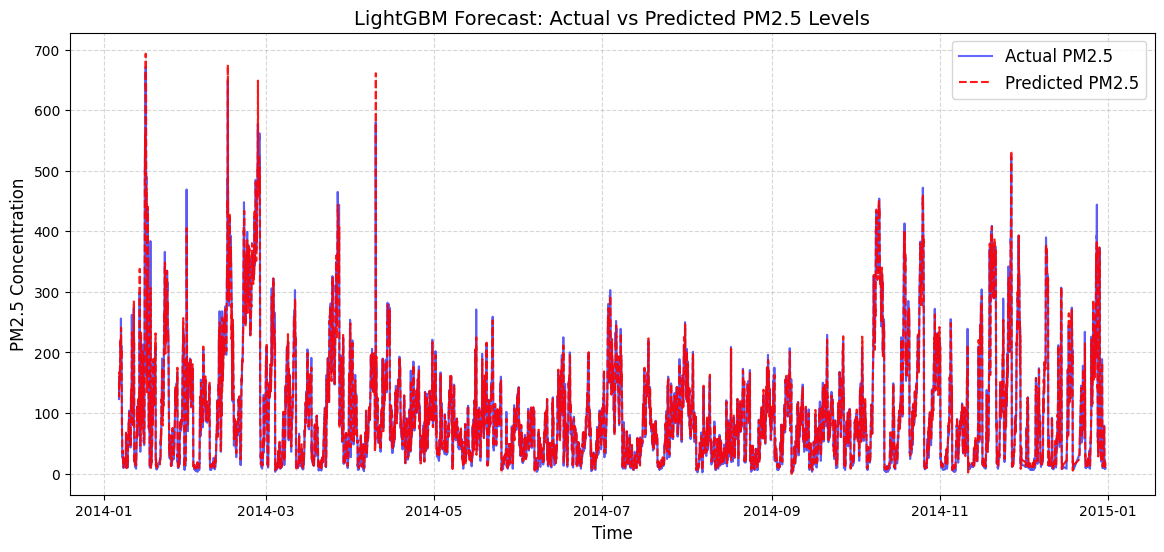

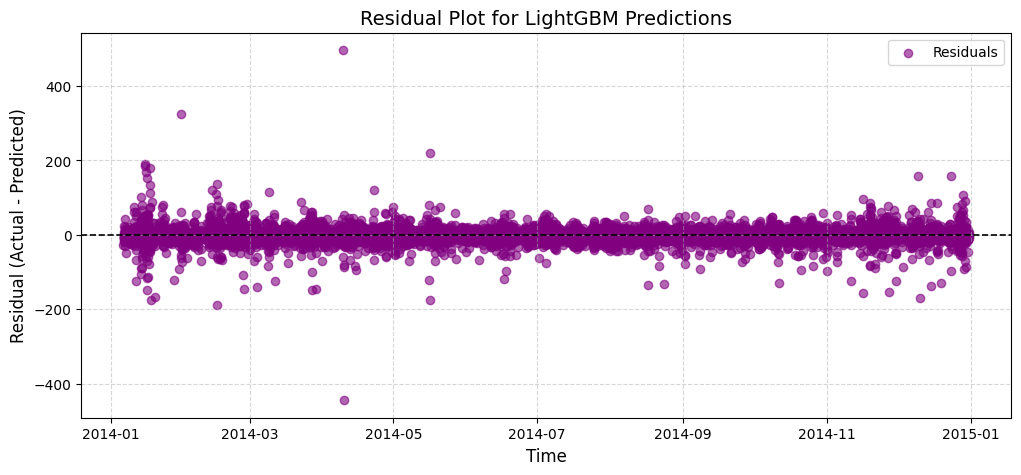

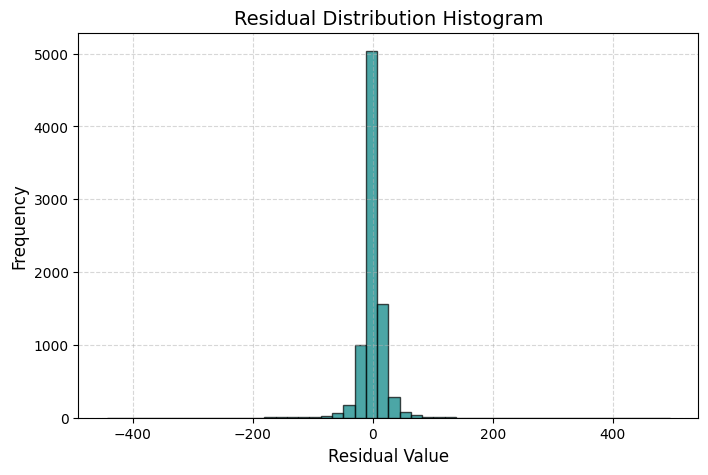

In [117]:
import matplotlib.pyplot as plt

# Improve the visualization
plt.figure(figsize=(14, 6))
plt.plot(results_df.index, results_df["Actual"], label="Actual PM2.5", color="blue", alpha=0.6, linewidth=1.5)
plt.plot(results_df.index, results_df["Predicted"], label="Predicted PM2.5", color="red", linestyle="dashed", alpha=0.9, linewidth=1.5)
plt.fill_between(results_df.index, results_df["Actual"], results_df["Predicted"], color="gray", alpha=0.2)  # Error shading

plt.xlabel("Time", fontsize=12)
plt.ylabel("PM2.5 Concentration", fontsize=12)
plt.title("LightGBM Forecast: Actual vs Predicted PM2.5 Levels", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

# Additional Visualization: Residual Plot (Actual - Predicted)
residuals = results_df["Actual"] - results_df["Predicted"]

plt.figure(figsize=(12, 5))
plt.scatter(results_df.index, residuals, color="purple", alpha=0.6, label="Residuals")
plt.axhline(y=0, color="black", linestyle="dashed", linewidth=1.2)  # Zero error reference line
plt.xlabel("Time", fontsize=12)
plt.ylabel("Residual (Actual - Predicted)", fontsize=12)
plt.title("Residual Plot for LightGBM Predictions", fontsize=14)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

# Additional Visualization: Distribution of Residuals
plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=50, color="teal", alpha=0.7, edgecolor="black")
plt.xlabel("Residual Value", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Residual Distribution Histogram", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()



**Air Quality Forecasting & Strategic Policy Recommendations**  

**1. Business Case for Predictive Air Quality Management**  

**Findings:**  
- **High seasonal variation in PM2.5 levels**, with pollution peaking in winter (Nov-Feb) due to heating emissions and atmospheric stagnation.  
 
- **The ACF and PACF confirm strong short-term predictability**, making PM2.5 forecasting viable.  
- **PM2.5 follows an AR(1) process**, making short-term forecasts highly reliable.  
- **LightGBM outperforms other models**, providing the most accurate air quality predictions.  


**Strategic Implications:**  
- **Proactive Pollution Control:** Predictive insights allow businesses and policymakers to implement **preemptive interventions** rather than reactive measures.  
- **Industry Compliance & Regulation:** Forecasting can **trigger automated restrictions on high-emission industries** based on expected pollution levels.  
- **Public Health & Risk Management:** Early warnings enable targeted **health advisories and transportation policies** to minimize exposure risks.  

---

**2. Meteorological Impact & Urban Infrastructure Optimization**  

**Findings:** 
- **Wind direction strongly influences pollution transport**, SE winds (May-Sept) facilitate natural air purification, whereas NW winds (Dec-Feb) transport pollution from industrial zones. 
- **Temperature and pressure variations correlate with PM2.5 concentration**, indicating that weather plays a critical role in pollution retention.  
- **Low wind speeds lead to stagnant air conditions**, trapping pollutants and worsening air quality.  

**Strategic Implications:**  
- **Wind Corridor Design:** Urban planning should **maximize airflow from cleaner SE winds** by designing open spaces and strategically placing green infrastructure.  
- **Smart City Adaptation:** Real-time wind forecasts should be integrated into **dynamic transportation and emissions control policies**.  
- **Industrial Relocation Strategy:** Industries emitting high pollutants should be **relocated away from major population centers and wind-sensitive regions**.  

---

**3. Handling Extreme Pollution Events & Outliers**  

**Findings:**  
- **Frequent outliers indicate hazardous pollution spikes** due to industrial activity, weather anomalies, and seasonal effects.  
- **PM2.5 levels can exceed 900 µg/m³**, far beyond safe air quality thresholds.  

**Strategic Implications:**  
- **Real-Time Crisis Management:** Establish an **AI-powered emergency response system** that triggers industrial restrictions and public safety advisories during extreme pollution events.  
- **Seasonal Emission Policies:** Implement **stricter regulations during winter months**, when pollution spikes are most severe.  
- **Health-Centric Public Policies:** Introduce **dynamic vehicle restriction zones and air purification strategies** during high-risk pollution periods.  

---

**4. Data-Driven Business & Policy Implementation Roadmap**  

**Short-Term (0-1 Year):**  
- Deploy **AI-powered air quality forecasting** for real-time policy and business decisions.  
- Enforce **dynamic emission regulations** based on predicted pollution spikes.  
- Establish **public alert systems** to provide timely health and safety guidance.  

**Medium-Term (1-3 Years):**  
- Develop **urban wind corridors** to improve air dispersion in high-risk areas.  
- Implement **automated pollution control systems** based on meteorological data.  
- Integrate **pollution-based transportation and logistics planning** into city infrastructure.  

**Long-Term (3-5 Years):**  
- Relocate **high-pollution industries** to minimize air quality risks in urban centers.  
- Implement **sustainable, wind-sensitive urban planning policies** to maintain long-term air quality.  
- Establish a **centralized AI-driven environmental management system**, integrating weather forecasting, pollution modeling, and industrial compliance tracking.  

---

**Business & Policy Impact:**  
- **Cost Reduction:** Predictive modeling minimizes economic losses from pollution-related health costs and productivity drops.  
- **Sustainability & Compliance:** Ensures businesses comply with evolving environmental regulations.  
- **Public Health Protection:** Reduces respiratory illnesses and improves urban livability.  

This **data-driven approach** ensures optimal **economic, environmental, and regulatory** balance, creating a **scalable and sustainable air quality management framework**.  
